In [1]:
import tensorflow as tf

tf.enable_eager_execution()

tfe = tf.contrib.eager

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")

In [3]:
from util import silhouette_plot, cluster_stability
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Preprocess DataFrame

In [4]:
df_main = pd.read_csv("zip_code_age_lg_wealth_osm_percentage.csv", index_col="Unnamed: 0")
df_main = df_main.drop(index=10020)  # missing all the data
df_main.head(2)

,female[0-9],male[0-9],female[10-19],male[10-19],female[20-29],male[20-29],female[30-39],male[30-39],female[40-49],male[40-49],...,"50,000-75,000","75,000-100,000","100,000-200,000","200,000-...",stadium_count,shoes_count,restaurant_count,gym_count,clothes_count,clinic_count
10026,0.059201,0.056966,0.058436,0.059289,0.094345,0.08111,0.092021,0.078905,0.083287,0.079199,...,0.136957,0.078261,0.100000,0.053261,0.0,0.0,18.0,0.0,0.0,1.0
10027,0.050966,0.050011,0.077194,0.067228,0.131140,0.10853,0.077478,0.069054,0.066776,0.061601,...,0.126863,0.064340,0.086514,0.046529,0.0,2.0,25.0,4.0,5.0,1.0


In [5]:
for osm in ['stadium', 'shoes', 'restaurant', 'gym', 'clothes', 'clinic']:
    col_name = f'{osm}_count'
    sparsity = np.sum(df_main[col_name]==0) / df_main.shape[0]
    print(f'{osm} sparsity: {sparsity}')

stadium sparsity: 0.9193548387096774
shoes sparsity: 0.43548387096774194
restaurant sparsity: 0.04838709677419355
gym sparsity: 0.5
clothes sparsity: 0.3870967741935484
clinic sparsity: 0.43548387096774194


In [6]:
mask = df_main.columns[df_main.columns!='stadium_count']
df_main = df_main[mask]
df_main.shape

(62, 26)

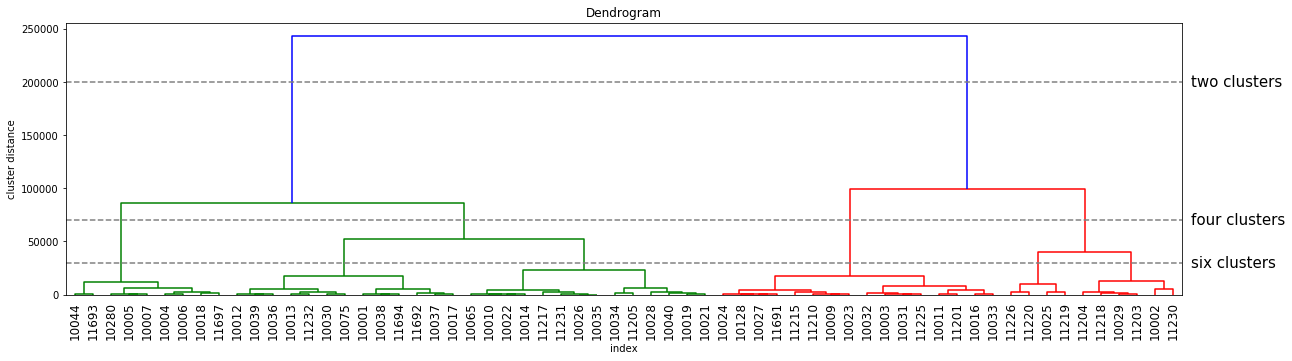

In [7]:
plt.figure(figsize=(20, 5))
linkage_array = ward(df_main)
dendrogram(linkage_array, leaf_font_size=12)

h_line = [200000, 70000, 30000]

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [h_line[0], h_line[0]], '--', c='grey')
ax.plot(bounds, [h_line[1], h_line[1]], '--', c='grey')
ax.plot(bounds, [h_line[2], h_line[2]], '--', c='grey')

ax.text(bounds[1]+5, h_line[0], 'two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[1], 'four clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[2], 'six clusters', va='center', fontdict={'size': 15})

ax.set_xlabel("index")
ax.set_ylabel("cluster distance")
ax.set_xticklabels([df_main.index[int(i.get_text())] for i in ax.get_xticklabels()])
ax.set_title("Dendrogram")
plt.show()

# Gradient Descent KMeams w/ SSE Objective Funtion 

In [24]:
N_ROWS, N_FEATURES = df_main.shape
MAT = tf.constant(df_main.values)
WEIGHTS = dict()

## Define the SSE Function

In [9]:
def sse_sum(weights, centers, labels):
    sse = tf.zeros([1, N_FEATURES], tf.float64)
    for i in range(N_ROWS):
        sse += (MAT * weights - centers[labels[i]])**2
    return tf.reduce_sum(sse)

## Gradient Function of SSE

In [10]:
grad_sse_sum = tfe.gradients_function(sse_sum, params=[0])

# Gradient Models

In [11]:
def inital_weights_sse(Model, lr):
    weights = tf.ones([1, N_FEATURES], tf.float64)

    mat_w = MAT * weights
    model = Model.fit(mat_w)
    
    centers = model.cluster_centers_
    labels = model.labels_
    sse_cur = sse_sum(weights, centers, labels)

    grad = grad_sse_sum(weights, centers, labels)[0]
    weights = weights - grad / tf.norm(grad) * lr
    weights /= tf.norm(weights)

    return weights, sse_cur

In [12]:
def gradient_kmeans(Model, lr, threshold, sse_prev, **initial):
    delta_sse = initial["delta_sse"] if "delta_sse" in initial else 2*(10**12)
    weights = initial["weights"] if "weights" in initial else tf.ones([1, N_FEATURES], tf.float64)
    
    sse_lt = list()
    while delta_sse > threshold:
        mat_w = MAT * weights
        model = Model.fit(mat_w)
        
        centers = model.cluster_centers_
        labels = model.labels_
        sse_cur = sse_sum(weights, centers, labels)
        

        grad = grad_sse_sum(weights, centers, labels)[0]
        weights = weights - grad / tf.norm(grad) * lr
        weights /= tf.norm(weights)
        
        delta_sse = tf.abs(sse_prev - sse_cur)
        sse_prev = sse_cur
        sse_lt.append(sse_cur)
        if not (len(sse_lt) % 50):
            print(f"Iter: {len(sse_lt)}, delta SSE: {delta_sse.numpy()}")

    print(f"\nFinal delta SSE: {delta_sse}")   
    return weights, delta_sse, sse_lt 
    

## KMeans (n = 3)

In [13]:
init_w, init_sse = inital_weights_sse(KMeans(n_clusters=3), lr=0.001)

In [14]:
w1, d_sse1, sse_lt1 = gradient_kmeans(KMeans(n_clusters=3), lr=0.001, threshold=150000, sse_prev=init_sse, weights=init_w)

Iter: 50, delta SSE: 1395655360.0012054
Iter: 100, delta SSE: 945895540.8891296
Iter: 150, delta SSE: 477596068.3860321
Iter: 200, delta SSE: 137992.48444164963

Final delta SSE: 137992.48444164963


In [20]:
w2, d_sse2, sse_lt2 = gradient_kmeans(KMeans(n_clusters=3), lr=0.0001, threshold=15000, sse_prev=sse_lt1[-1], weights=w1, delta_sse=d_sse1)

Iter: 50, delta SSE: 17386.962613041047
Iter: 100, delta SSE: 16881.63405074482
Iter: 150, delta SSE: 16429.204770932614
Iter: 200, delta SSE: 15923.064972927445
Iter: 250, delta SSE: 15640.408741252613
Iter: 300, delta SSE: 15200.568952267175

Final delta SSE: 14992.771924840927


In [21]:
w3, d_sse3, sse_lt3 = gradient_kmeans(KMeans(n_clusters=3), lr=0.00001, threshold=1, sse_prev=sse_lt1[-1], weights=w2, delta_sse=d_sse2)

Iter: 50, delta SSE: 42.56118474208051
Iter: 100, delta SSE: 13.027002580347471
Iter: 150, delta SSE: 2.209502650250215

Final delta SSE: 0.8377445990336128


In [22]:
silhouette_score(MAT*w3, KMeans(n_clusters=3).fit(MAT*w3).labels_)

0.5945518141893216

In [26]:
WEIGHTS[3] = w3